In [1761]:
from sklearn.datasets._samples_generator import make_blobs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

X, y_true = make_blobs(n_samples=50, centers=4, n_features=3,
                       cluster_std=0.60, random_state=0,)

In [1762]:
def WireframeSphere(centre=[0.,0.,0.], radius=1.,
                    n_meridians=20, n_circles_latitude=None):
    """
    Create the arrays of values to plot the wireframe of a sphere.

    Parameters
    ----------
    centre: array like
        A point, defined as an iterable of three numerical values.
    radius: number
        The radius of the sphere.
    n_meridians: int
        The number of meridians to display (circles that pass on both poles).
    n_circles_latitude: int
        The number of horizontal circles (akin to the Equator) to display.
        Notice this includes one for each pole, and defaults to 4 or half
        of the *n_meridians* if the latter is larger.

    Returns
    -------
    sphere_x, sphere_y, sphere_z: arrays
        The arrays with the coordinates of the points to make the wireframe.
        Their shape is (n_meridians, n_circles_latitude).

    Examples
    --------
    >>> fig = plt.figure()
    >>> ax = fig.gca(projection='3d')
    >>> ax.set_aspect("equal")
    >>> sphere = ax.plot_wireframe(*WireframeSphere(), color="r", alpha=0.5)
    >>> fig.show()

    >>> fig = plt.figure()
    >>> ax = fig.gca(projection='3d')
    >>> ax.set_aspect("equal")
    >>> frame_xs, frame_ys, frame_zs = WireframeSphere()
    >>> sphere = ax.plot_wireframe(frame_xs, frame_ys, frame_zs, color="r", alpha=0.5)
    >>> fig.show()
    """
    if n_circles_latitude is None:
        n_circles_latitude = max(n_meridians/2, 4)
    u, v = np.mgrid[0:2*np.pi:n_meridians*1j, 0:np.pi:n_circles_latitude*1j]
    sphere_x = centre[0] + radius * np.cos(u) * np.sin(v)
    sphere_y = centre[1] + radius * np.sin(u) * np.sin(v)
    sphere_z = centre[2] + radius * np.cos(v)
    return sphere_x, sphere_y, sphere_z

In [1763]:
X_df = pd.DataFrame(X)
X_df.head()

,0,1,2
0,1.164111,3.791330,0.523474
1,1.176475,5.200235,1.932173
2,0.486778,-2.049382,2.570572
3,1.079147,-1.907497,2.700238
4,-2.093566,5.178664,-0.316856


In [1764]:
sns.set()

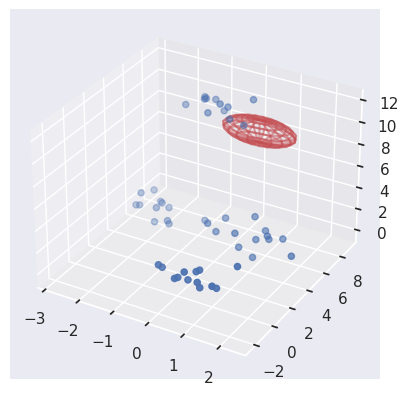

In [1765]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
sphere = ax.plot_wireframe(*WireframeSphere([1,5,11]), color="r", alpha=0.5)
ax.scatter(X_df[0], X_df[1], X_df[2])

plt.show()

### The algorithms
In comparison to 2D-Laplace there are three separate formulas to generate the PDF. These look a lot like the ones for 2D-Laplace, but use a shape 3 of the gamma distribution and include the azimuth angle.

In [1766]:
from scipy.stats import gamma

In [1767]:
radius = 0.5 # radius r
level = 2 #privacy level l
epsilon = level/radius
print(epsilon)

4.0


The azimuth ($\psi$) and theta ($\theta$) is generated using this paper: Generalised Differential Privacy for Text Document
Processing

In [1768]:
def generate_unit_sphere(): 
    vector = np.random.randn(3)
    vector /= np.linalg.norm(vector)

    #polar_angle = np.arccos(vector[2])
    #azimuth = np.arctan2(vector[1], vector[0])
    theta = np.random.uniform(0, 2*np.pi)
    psi = np.arccos(2*np.random.uniform() - 1)
    return theta, psi, vector

In [1769]:
def plot_unit_shere(ax, vector): 
    theta = np.linspace(0, 2*np.pi, 100)
    phi = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(theta), np.sin(phi))
    y = np.outer(np.sin(theta), np.sin(phi))
    z = np.outer(np.ones(np.size(theta)), np.cos(phi))
    ax.scatter(0, 0, 0, c='r', marker='o')
    ax.quiver(0, 0, 0, vector[0], vector[1], vector[2], length=1, normalize=False)

    #plt.scatter(0, 0, z, c='g', marker='o')
    ax.plot_surface(x, y, z, color='b', alpha=0.2, linewidth=0.1)

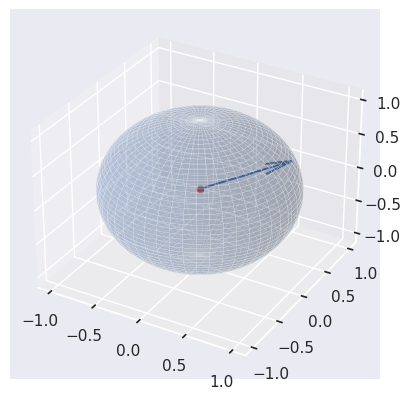

In [1770]:
polar_angle, azimuth, vector = generate_unit_sphere()
plt.figure()
ax = plt.subplot(111, projection='3d')
plot_unit_shere(ax, vector)

In [1805]:
from sklearn.preprocessing import StandardScaler

def generate_3D_noise(epsilon): 
    polar_angle, azimuth, _ = generate_unit_sphere() # theta, psi
    r = gamma.rvs(3, scale=1/epsilon)
    # theta = 2 * np.pi * u[0]
    #theta = np.random.rand() * np.pi
    #phi = np.arccos(2 * u[1] - 1)
    #phi = np.random.rand() * np.pi*2 # 
    return r * np.sin(polar_angle) * np.sin(azimuth), r * np.sin(polar_angle) * np.cos(azimuth), r * np.cos(polar_angle)

def euclidean_distance(p1, p2):
    return np.linalg.norm(p2 - p1)

def calculate_radius_with_noise(x0, n, epsilon): 
    """
        x0: Point to perturb
        n: amount of points to generate
        epsilon: privacy budget
    """
    Z = []
    total_dis = 0
    for nm in range(0, n):
        noise = generate_3D_noise(epsilon)
        z = x0 + noise;
        total_dis = total_dis + euclidean_distance(x0, z)
        Z.append(z)

    R = total_dis / n
    return np.array(Z), R

def display_noise(x0, epsilon, ax, amount_of_points = 10): 
    Z, R = calculate_radius_with_noise(x0, amount_of_points, epsilon)
    ax.plot_wireframe(*WireframeSphere(x0, radius=R*np.pi), color="r", alpha=0.2)
    
    return Z
def display_data_as_scatterplot(X, ax): 
    X_prime = StandardScaler().fit_transform(X)
    #ax.scatter(x_0[0], x_0[1], x_0[2], c='r')
    ax.scatter(X_prime[:,0], X_prime[:,1], X_prime[:,2], c='b')
    return X_prime

def generate_3D_noise_for_dataset(X, epsilon):
    Z = []
    for x in X:
        noise = generate_3D_noise(epsilon)
        z = x + noise
        Z.append(z)
    return Z

def display_perturbed_data(Z, ax):
    Z_prime = StandardScaler().fit_transform(Z)
    ax.scatter(Z_prime[:,0], Z_prime[:,1], Z_prime[:,2], c='g')

def plot_row_with_epsilon_scores(X, epsilons, ax, row = 1): 
    i = 0
    for epsilon in epsilons:
        i += 1
        ax = fig.add_subplot(row, len(epsilons), i, projection='3d')
        ax.set_title('Epsilon ' + str(epsilon))
        display_data_as_scatterplot(X, ax)
        Z = generate_3D_noise_for_dataset(X, epsilon)
        display_perturbed_data(Z, ax)

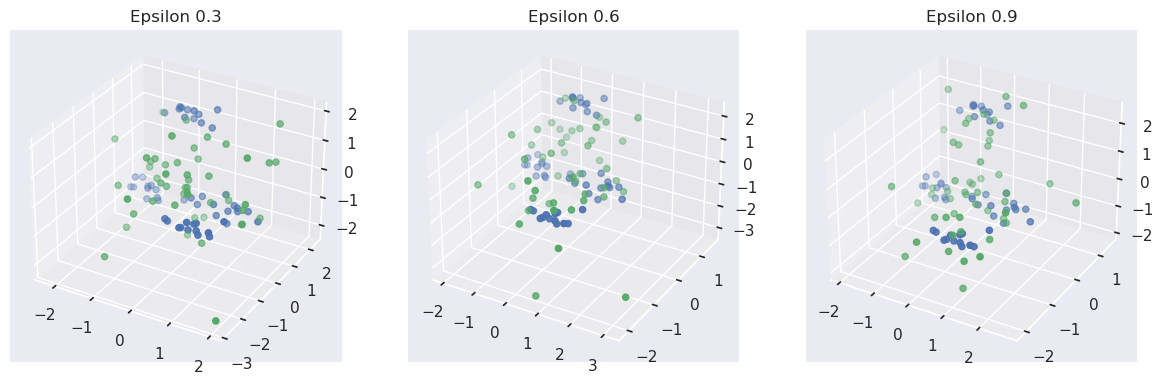

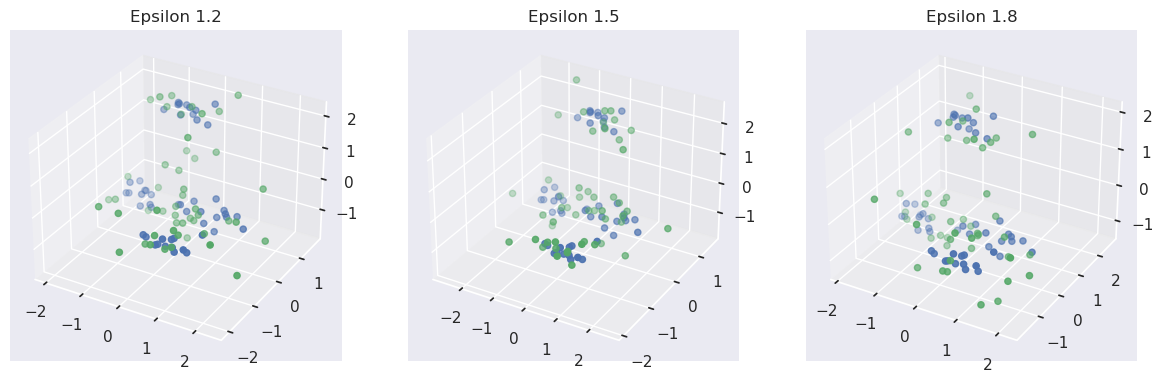

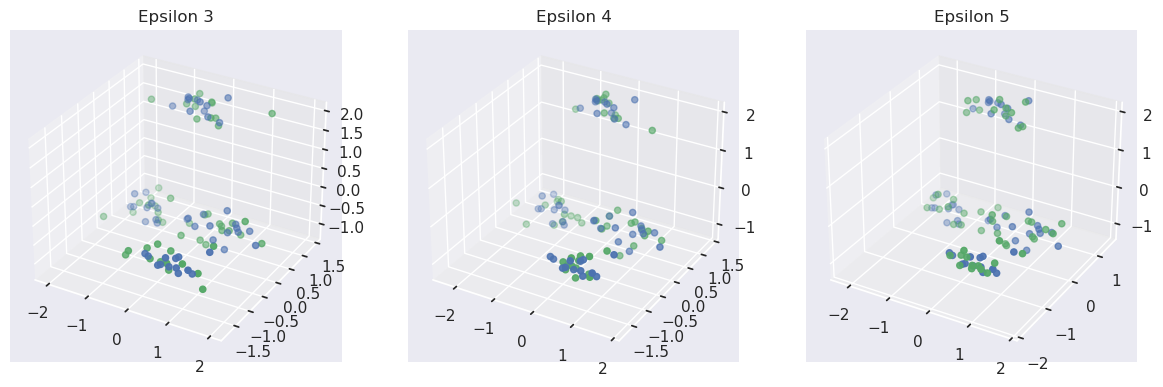

In [1810]:
radius = 0.5 # radius r
level = 2 #privacy level l
epsilon = level/radius
fig = plt.figure(figsize=plt.figaspect(0.33))
plot_row_with_epsilon_scores(X, [0.3, 0.6, 0.9], fig)
plt.show()

fig = plt.figure(figsize=plt.figaspect(0.33))
plot_row_with_epsilon_scores(X, [1.2, 1.5, 1.8], fig)

fig = plt.figure(figsize=plt.figaspect(0.33))
plot_row_with_epsilon_scores(X, [3, 4, 5], fig)

